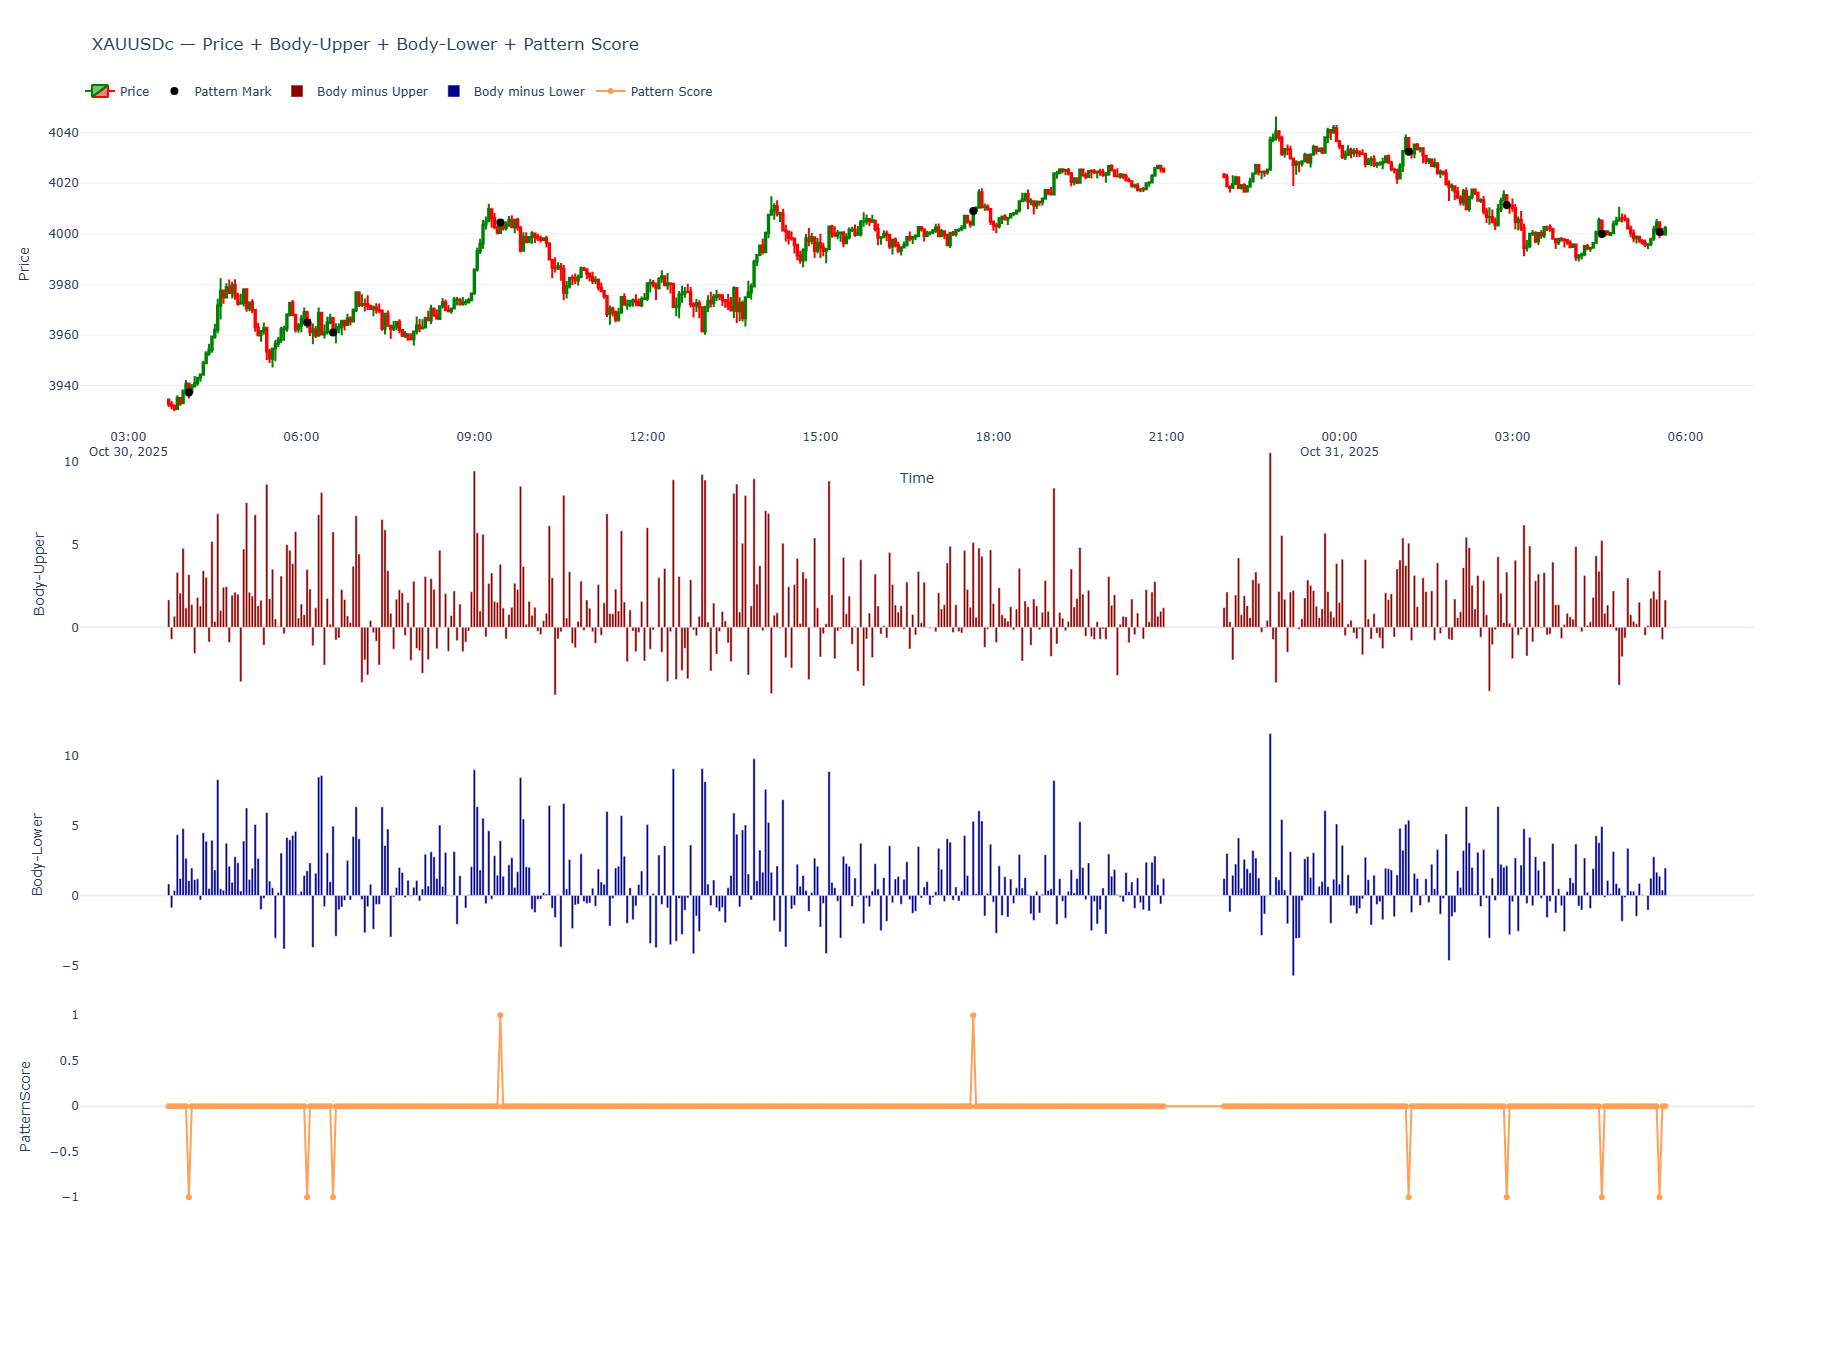

In [5]:
import MetaTrader5 as mt5 
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------
# Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=44)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)
df = df[df.index.dayofweek < 5]

# -------------------------
# Calculations needed
# -------------------------
df['body'] = abs(df['close'] - df['open'])
df['upper_wick'] = df['high'] - df[['open','close']].max(axis=1)
df['lower_wick'] = df[['open','close']].min(axis=1) - df['low']

df['body_minus_upper'] = df['body'] - df['upper_wick']
df['body_minus_lower'] = df['body'] - df['lower_wick']

# -------------------------
# Pattern Score Logic with positive body-upper & body-lower requirement
# -------------------------
pattern_score = []
pattern_mark = []

for i in range(len(df)):
    if i < 2:
        pattern_score.append(0)
        pattern_mark.append(np.nan)
        continue

    i0 = i
    i1 = i - 1
    i2 = i - 2

    o0, h0, l0, c0 = df['open'].iloc[i0], df['high'].iloc[i0], df['low'].iloc[i0], df['close'].iloc[i0]
    o1, h1, l1, c1 = df['open'].iloc[i1], df['high'].iloc[i1], df['low'].iloc[i1], df['close'].iloc[i1]
    o2, h2, l2, c2 = df['open'].iloc[i2], df['high'].iloc[i2], df['low'].iloc[i2], df['close'].iloc[i2]

    # Required condition: body-upper and body-lower must ALL be positive for 0, -1, -2
    valid_bu_bl = (
        df['body_minus_upper'].iloc[i0] > 0 and df['body_minus_lower'].iloc[i0] > 0 and
        df['body_minus_upper'].iloc[i1] > 0 and df['body_minus_lower'].iloc[i1] > 0 and
        df['body_minus_upper'].iloc[i2] > 0 and df['body_minus_lower'].iloc[i2] > 0
    )

    if not valid_bu_bl:
        pattern_score.append(0)
        pattern_mark.append(np.nan)
        continue

    curr_bearish = c0 < o0
    curr_bullish = c0 > o0

    prev_bullish = c1 > o1
    prev_bearish = c1 < o1

    prev2_bullish = c2 > o2
    prev2_bearish = c2 < o2

    score = 0
    mark = np.nan

    # ---------------------------------------
    # Bearish Pattern
    # ---------------------------------------
    if curr_bearish and prev_bullish and prev2_bullish:
        if (c0 < o1) and (h1 > h2) and (h1 > h0):
            score = -1
            mark = c0

    # ---------------------------------------
    # Bullish Pattern
    # ---------------------------------------
    if curr_bullish and prev_bearish and prev2_bearish:
        if (c0 > o1) and (l1 < l2) and (l1 < l0):
            score = 1
            mark = c0

    pattern_score.append(score)
    pattern_mark.append(mark)

df['pattern_score'] = pattern_score
df['pattern_mark'] = pattern_mark

# -------------------------
# Plot: Price + Body-Upper + Body-Lower + Pattern Score
# -------------------------
fig = go.Figure()

# Pane 1 — Price
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='Price',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Pattern Markers
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['pattern_mark'],
    mode='markers',
    marker=dict(size=8, color='black'),
    name='Pattern Mark'
))

# Pane 2 — Body minus upper wick
fig.add_trace(go.Bar(
    x=df.index,
    y=df['body_minus_upper'],
    name='Body minus Upper',
    marker_color='darkred',
    yaxis='y2'
))

# Pane 3 — Body minus lower wick
fig.add_trace(go.Bar(
    x=df.index,
    y=df['body_minus_lower'],
    name='Body minus Lower',
    marker_color='darkblue',
    yaxis='y3'
))

# Pane 4 — Pattern Score
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['pattern_score'],
    mode='lines+markers',
    name='Pattern Score',
    marker=dict(size=6),
    yaxis='y4'
))

# Layout
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc — Price + Body-Upper + Body-Lower + Pattern Score',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),

    yaxis=dict(title='Price',         domain=[0.72, 1]),
    yaxis2=dict(title='Body-Upper',   domain=[0.48, 0.71], showgrid=False),
    yaxis3=dict(title='Body-Lower',   domain=[0.24, 0.47], showgrid=False),
    yaxis4=dict(title='PatternScore', domain=[0.05, 0.23], showgrid=False),

    legend=dict(orientation='h', y=1.02, x=0),
    height=1350
)

fig.show()


Perform a backtest where, if the 'pattern mark ' appears, buy and sell at the close of the corresponding candle. The stop-loss is worth 5 price units, and the take-profit is 2R-multiple. Conduct a realistic backtest, making the trade execution similar to a live environment. 1% risk per trade with inital capital of 1000. Mark the entry to stoploss using a red breakline, and a green breakline if from entry to takeprofit. Plot the Equity Curve with a drawdown percentage on a separate pane. Place both sell orders and buyorders for each signal. Use a red bar chart in presenting the drawdown %, and a gold line chart in presenting the equity curve.

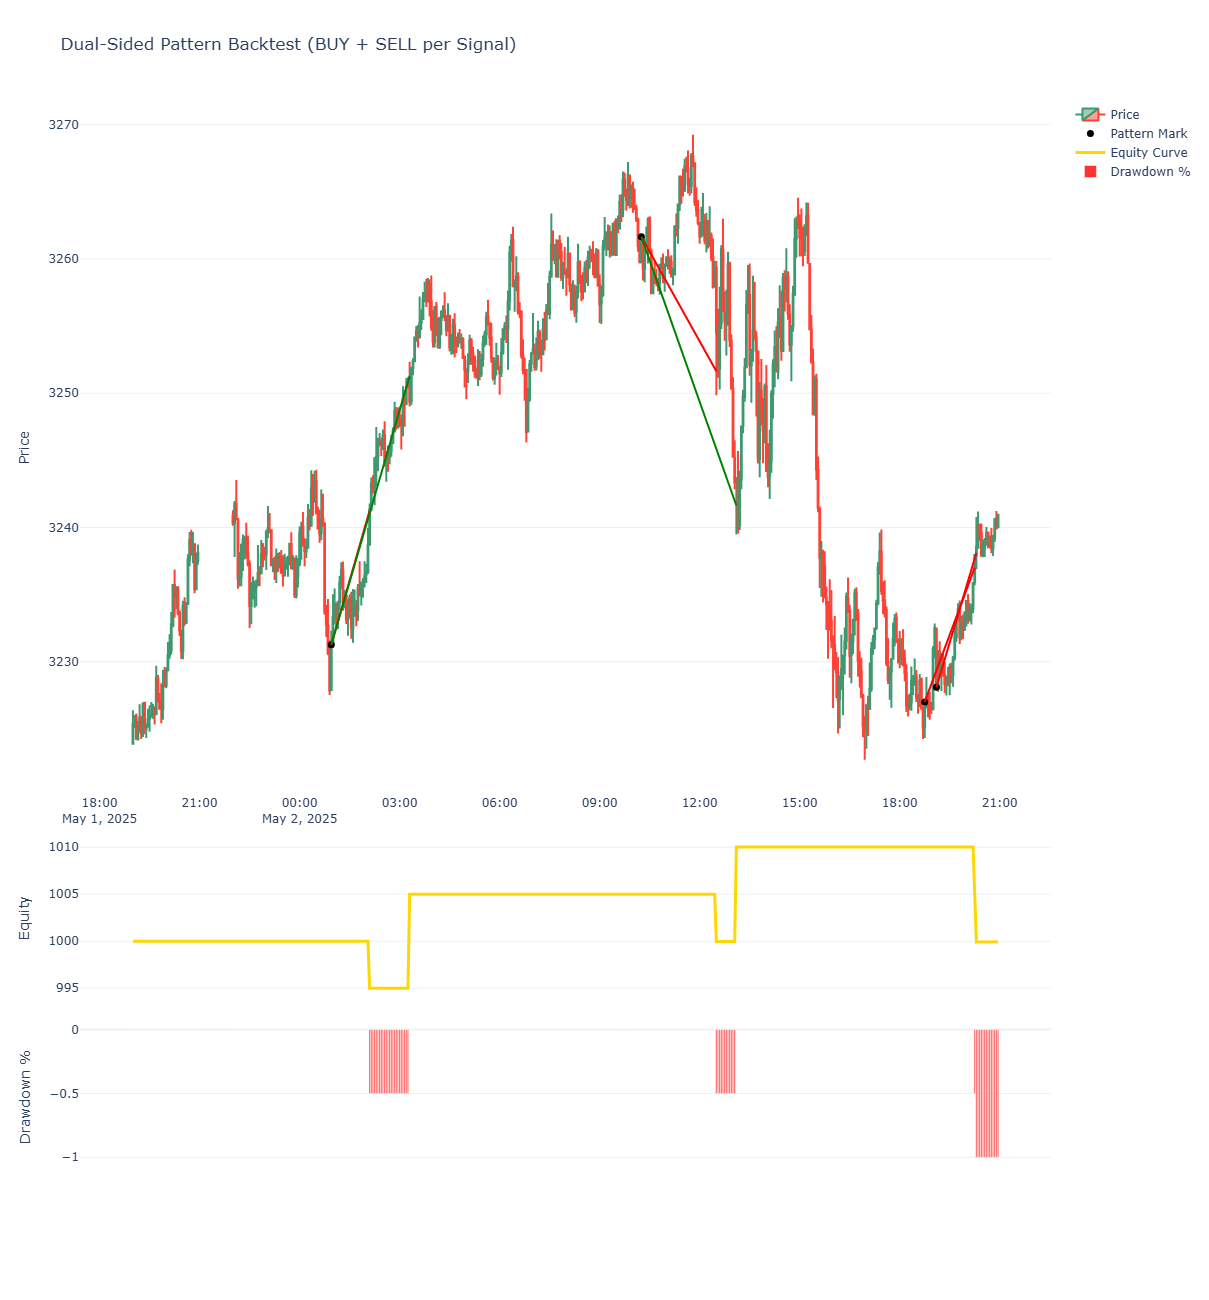

In [18]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------
# Initialize MT5
# -------------------------
if not mt5.initialize():
    raise RuntimeError("MT5 initialization failed")

# -------------------------
# Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=224)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)
df = df[df.index.dayofweek < 5]

# -------------------------
# Candle Calculations
# -------------------------
df['body'] = abs(df['close'] - df['open'])
df['upper_wick'] = df['high'] - df[['open','close']].max(axis=1)
df['lower_wick'] = df[['open','close']].min(axis=1) - df['low']

df['body_minus_upper'] = df['body'] - df['upper_wick']
df['body_minus_lower'] = df['body'] - df['lower_wick']

# -------------------------
# Pattern Detection
# -------------------------
pattern_score = []
pattern_mark = []

for i in range(len(df)):
    if i < 2:
        pattern_score.append(0)
        pattern_mark.append(np.nan)
        continue

    valid_bu_bl = (
        df['body_minus_upper'].iloc[i] > 0 and df['body_minus_lower'].iloc[i] > 0 and
        df['body_minus_upper'].iloc[i-1] > 0 and df['body_minus_lower'].iloc[i-1] > 0 and
        df['body_minus_upper'].iloc[i-2] > 0 and df['body_minus_lower'].iloc[i-2] > 0
    )

    if not valid_bu_bl:
        pattern_score.append(0)
        pattern_mark.append(np.nan)
        continue

    o0,c0 = df['open'].iloc[i], df['close'].iloc[i]
    o1,c1 = df['open'].iloc[i-1], df['close'].iloc[i-1]
    o2,c2 = df['open'].iloc[i-2], df['close'].iloc[i-2]
    h0,h1,h2 = df['high'].iloc[i], df['high'].iloc[i-1], df['high'].iloc[i-2]
    l0,l1,l2 = df['low'].iloc[i], df['low'].iloc[i-1], df['low'].iloc[i-2]

    score = 0
    mark = np.nan

    if c0 < o0 and c1 > o1 and c2 > o2:
        if c0 < o1 and h1 > h2 and h1 > h0:
            score = -1
            mark = c0

    if c0 > o0 and c1 < o1 and c2 < o2:
        if c0 > o1 and l1 < l2 and l1 < l0:
            score = 1
            mark = c0

    pattern_score.append(score)
    pattern_mark.append(mark)

df['pattern_score'] = pattern_score
df['pattern_mark'] = pattern_mark

# -------------------------
# BACKTEST ENGINE
# -------------------------
capital = 1000.0
risk_total = 0.01
risk_per_trade = risk_total / 2
stop_dist = 10.0
rr = 2.0

open_trades = []
equity_curve = []
drawdown = []
trade_lines = []

peak_equity = capital

for i in range(len(df)):
    time = df.index[i]
    close_price = df['close'].iloc[i]
    high = df['high'].iloc[i]
    low = df['low'].iloc[i]

    # Manage open trades
    for trade in open_trades.copy():
        d = trade['dir']
        hit_tp = high >= trade['tp'] if d == 1 else low <= trade['tp']
        hit_sl = low <= trade['sl'] if d == 1 else high >= trade['sl']

        if hit_tp or hit_sl:
            exit_price = trade['tp'] if hit_tp else trade['sl']
            pnl = (exit_price - trade['entry']) * trade['size'] * d
            capital += pnl

            trade_lines.append(dict(
                x=[trade['time'], time],
                y=[trade['entry'], exit_price],
                color='green' if hit_tp else 'red'
            ))

            open_trades.remove(trade)

    # New signal → BUY + SELL
    if df['pattern_score'].iloc[i] != 0:
        risk_amount = capital * risk_per_trade
        size = risk_amount / stop_dist

        open_trades.append(dict(
            dir=1,
            entry=close_price,
            sl=close_price - stop_dist,
            tp=close_price + stop_dist * rr,
            size=size,
            time=time
        ))

        open_trades.append(dict(
            dir=-1,
            entry=close_price,
            sl=close_price + stop_dist,
            tp=close_price - stop_dist * rr,
            size=size,
            time=time
        ))

    equity_curve.append(capital)
    peak_equity = max(peak_equity, capital)
    drawdown.append((capital - peak_equity) / peak_equity * 100)

df['equity'] = equity_curve
df['drawdown'] = drawdown

# -------------------------
# PLOTTING
# -------------------------
fig = go.Figure()

# Price
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='Price'
))

# Pattern Marks
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['pattern_mark'],
    mode='markers',
    marker=dict(color='black', size=7),
    name='Pattern Mark'
))

# Trade Lines
for t in trade_lines:
    fig.add_trace(go.Scatter(
        x=t['x'],
        y=t['y'],
        mode='lines',
        line=dict(color=t['color'], width=2),
        showlegend=False
    ))

# Equity Curve — GOLD LINE
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['equity'],
    name='Equity Curve',
    yaxis='y2',
    line=dict(color='gold', width=3)
))

# Drawdown — RED BAR
fig.add_trace(go.Bar(
    x=df.index,
    y=df['drawdown'],
    name='Drawdown %',
    yaxis='y3',
    marker=dict(color='red'),
    opacity=0.8
))

fig.update_layout(
    template='plotly_white',
    title='Dual-Sided Pattern Backtest (BUY + SELL per Signal)',
    xaxis=dict(rangeslider=dict(visible=False)),

    yaxis=dict(domain=[0.38, 1], title='Price'),
    yaxis2=dict(domain=[0.20, 0.34], title='Equity'),
    yaxis3=dict(domain=[0.05, 0.17], title='Drawdown %'),

    height=1300
)

fig.show()
